In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers

# Generate CM Data to CM model folder
from fibre_ml_libs_output_power import *

print("TensorFlow version:", tf.__version__)
tf.random.set_seed(256)

checkIfTransferModelHasTrained = False 
frozenBatchNormalization = True # if the model are close, frozen the BatchNormalization

trainCSV_postName = ".csv"
testCSV_random_postName  = ".csv"

# prePath
CVS_prepath = "../feature2/"
# CVS_prepath2 = "../feature2/"

figure_prepath = "../figure/"
model_prepath = "../model/"

# graph Name
figureFrontSize = 12
figureName_post = ".png"
model_postName = "" 

# ML model for testing 
dropout_rate = 0.0 

Train_25_7_random="25km_random_train"
Test_25_7_random="25km_random_test"

Train_50_7_random="50km_random_train"
Test_50_7_random="50km_random_test"

Train_50_3_random="50km_random3_train"
Test_50_3_random="50km_random3_test"

Train_25_3_random="25km_random3_train"
Test_25_3_random="25km_random3_test"

Train_50_4_random="50km_random4_train"
Test_50_4_random="50km_random4_test"

Train_50_4_random_out="50km_random4_out_train"
Test_50_4_random_out="50km_random4_out_test"

Train_50_4_random_out="50km_random4_out_train"
Test_50_4_random_out="50km_random4_out_test"

_50_4_step="50km_step4"
_50_4_goalpost="50km_goalpost4"

Train_25_4_random="25km_random4_train"
Test_25_4_random="25km_random4_test"

Train_25_4_random_out="25km_random4_out_train"
Test_25_4_random_out="25km_random4_out_test"

Train_25_4_random_out="25km_random4_out_train"
Test_25_4_random_out="25km_random4_out_test"

_25_4_step="25km_step4"
_25_4_goalpost="25km_goalpost4"
# some parameters tmp 
# model details
baseEpoch = 40
tlEpoch = 20
trainingStepSize = 5e-5

TensorFlow version: 2.14.0


In [2]:
def tl_model(base_model, outputNum=1, stepSize=0.01, dropout=0.5, clipnormSize=1.5):
  for layer in base_model.layers:
      layer.trainable = False

  new_base_model = keras.models.Model(inputs=base_model.input,
                                      outputs=base_model.layers[-2].output)

  model = keras.Sequential()
  model.add(new_base_model)
  model.add(layers.Dense(512, kernel_initializer="he_normal"))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU())
  model.add(layers.Dropout(rate=dropout))
  model.add(layers.Dense(outputNum, kernel_initializer="he_normal"))

  model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.legacy.Adam(learning_rate=stepSize, clipnorm=clipnormSize)
    )

  return model

def train_tl_model(base_model, trainName,testName, epochs, callbacks=None):
  # get dataset names
  trainCSV = trainName + trainCSV_postName
  testCSV  = testName + testCSV_random_postName 

  # get model name
  TrainModelName = model_prepath+ trainName+model_postName

  ### get data
  X_train, y_train = getCSVData(CVS_prepath + trainCSV)
  X_test, y_test = getCSVData(CVS_prepath + testCSV)

  ### train model
  model = tl_model(base_model, outputNum=1,stepSize=trainingStepSize,dropout=dropout_rate,clipnormSize=3.)
  #base_model.summary()
  print(X_train.shape,y_train.shape)

  history_tl = model.fit(
    X_train,
    y_train,
    validation_data=(X_test,y_test),
    # batch_size=8,
  verbose=2, epochs=epochs, callbacks=callbacks) # 150
  base_model.save_weights(TrainModelName)
  return model

def dnn_model(outputNum,stepSize=0.01,dropout=0.5,clipnormSize=1.5):
  # dimension_sizes = [num_inputFeatures,128,64,32,16,8,4,outputNum]
  #print(num_inputFeatures)
  # dimension_sizes = [num_inputFeatures,128,128,64,64,32,32,16,16,outputNum]
  dimension_sizes = [num_inputFeatures,64,64,2,64,64,outputNum]

  model = keras.Sequential()
  for di_index in range(len(dimension_sizes)):
    dimension_size = dimension_sizes[di_index]
    if di_index < len(dimension_sizes) - 1:
      model.add(layers.Dense(dimension_size, kernel_initializer="he_normal"))
      model.add(layers.BatchNormalization())
      model.add(layers.ELU())
      model.add(layers.Dropout(rate=dropout))
    else: # last layer
      model.add(layers.Dense(dimension_size, kernel_initializer="he_normal"))

  model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.legacy.Adam(stepSize, clipnorm=clipnormSize),
              metrics=['mae'])  # Add 'mae' to the metrics here
  return model

def train_base_model2(trainName,testName,epochs, callbacks = None):
    # get dataset names
    trainCSV = trainName + trainCSV_postName
    testCSV  = testName + testCSV_random_postName 
    
    # get model name
    TrainModelName = model_prepath+ trainName+model_postName

    ### get data
    X_train, y_train = getCSVData(CVS_prepath + trainCSV)
    X_test, y_test = getCSVData(CVS_prepath + testCSV)

    ### train model
    model = dnn_model(
        outputNum=1,stepSize=trainingStepSize,dropout=dropout_rate,clipnormSize=3.
    )
    #base_model.summary()
    print(X_train.shape,y_train.shape)
    history_dnn = model.fit(
      X_train,
      y_train,
      validation_data=(X_test,y_test),
      # batch_size=8,
      verbose=2, epochs=epochs, callbacks = callbacks)
    model.save_weights(TrainModelName)
    plot_loss(1,history_dnn,10)
    return model

def getCSVData(fileName):

  trainData = pd.read_csv(fileName,index_col=None)

  X_train = trainData.copy()
  y_train = pd.concat([X_train.pop(x) for x in result_labels], axis=1)
  # for x in drop_labels: X_train.pop(x)

  return X_train,y_train

def plot_loss(indx,history,ingnoreIndex):
  plt.figure(indx)
  plt.plot(history.history['loss'][ingnoreIndex:], label='loss')
  plt.plot(history.history['val_loss'][ingnoreIndex:], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [gain]')
  plt.legend()
  plt.grid(True)

def evaluate_a_model(model,testName):
    testCSV  = testName + testCSV_random_postName 
    X_test,y_test = getCSVData(CVS_prepath + testCSV)

    # convert linear to dB
    y_Pred = model.predict(X_test)
    y_Pred = divideZero(y_Pred*y_test,y_test) # unloaded the channel

    Error = y_test - y_Pred
    Error.replace(0, np.nan, inplace=True)
    return Error # not abs error

def save_a_error(error,result,label):
    result[label] = error # np.abs(error)
    return result

# visualization of result matrix
def visualize_a_matrix():
    pass

(880, 3) (880, 1)
Epoch 1/500
28/28 - 1s - loss: 84.7892 - mae: 8.7009 - val_loss: 158.8329 - val_mae: 11.9258 - 780ms/epoch - 28ms/step
Epoch 2/500
28/28 - 0s - loss: 80.9817 - mae: 8.6324 - val_loss: 126.6988 - val_mae: 10.6059 - 45ms/epoch - 2ms/step
Epoch 3/500
28/28 - 0s - loss: 78.3346 - mae: 8.5801 - val_loss: 94.2851 - val_mae: 9.1971 - 43ms/epoch - 2ms/step
Epoch 4/500
28/28 - 0s - loss: 76.5541 - mae: 8.5297 - val_loss: 88.2205 - val_mae: 8.9684 - 44ms/epoch - 2ms/step
Epoch 5/500
28/28 - 0s - loss: 74.9691 - mae: 8.4766 - val_loss: 74.6878 - val_mae: 8.3217 - 44ms/epoch - 2ms/step
Epoch 6/500
28/28 - 0s - loss: 73.5475 - mae: 8.4211 - val_loss: 76.5876 - val_mae: 8.4616 - 44ms/epoch - 2ms/step
Epoch 7/500
28/28 - 0s - loss: 71.8096 - mae: 8.3503 - val_loss: 72.9881 - val_mae: 8.3214 - 44ms/epoch - 2ms/step
Epoch 8/500
28/28 - 0s - loss: 70.9910 - mae: 8.3038 - val_loss: 67.2630 - val_mae: 8.0598 - 44ms/epoch - 2ms/step
Epoch 9/500
28/28 - 0s - loss: 69.9299 - mae: 8.2524 - v

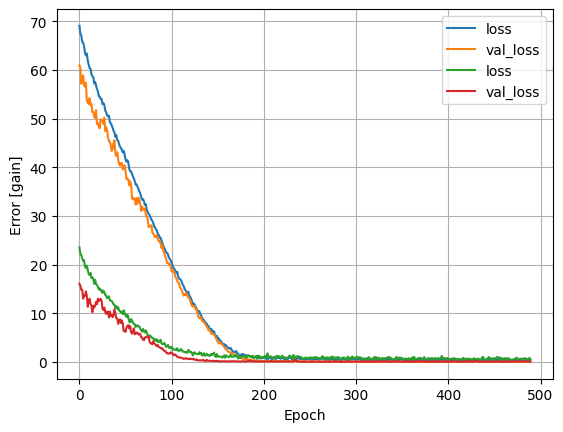

In [4]:
base_model_25_random4_out = train_base_model2(Train_25_4_random_out, Test_25_4_random_out, epochs=200)
base_model_50_random4_out = train_base_model2(Train_50_4_random_out, Test_50_4_random_out, epochs=200)

In [8]:
import time

# Initialize a dictionary to store each model's training time
training_times = {}

# Define a function to train models and record their training time
def train_model_and_record_time(model_name, train_function, base_model, train_dataset, test_dataset, epochs):
    start_time = time.time()  # Record the start time of training
    model = train_function(base_model, train_dataset, test_dataset, epochs=epochs)
    training_time = time.time() - start_time  # Calculate the training time
    training_times[model_name] = training_time  # Store the training time in the dictionary
    return model

# Train models and record the time
TL_model_25_random4_from_50_random_75_out = train_model_and_record_time(
    "TL_model_50_random4_from_25_random_50_out", train_tl_model, base_model_50_random4_out, Train_25_4_random_out, Test_25_4_random_out, 75)

TL_model_25_random4_from_50_random_150_out = train_model_and_record_time(
    "TL_model_25_random4_from_50_random_100_out", train_tl_model, base_model_50_random4_out, Train_25_4_random_out, Test_25_4_random_out, 150)

TL_model_50_random4_from_25_random_75_out = train_model_and_record_time(
    "TL_model_50_random4_from_25_random_50_out", train_tl_model, base_model_25_random4_out, Train_50_4_random_out, Test_50_4_random_out, 75)

TL_model_50_random4_from_25_random_150_out = train_model_and_record_time(
    "TL_model_50_random4_from_25_random_100_out", train_tl_model, base_model_25_random4_out, Train_50_4_random_out, Test_50_4_random_out, 150)

TL_model_25_random4_from_25_random_75_out = train_model_and_record_time(
    "TL_model_50_random4_from_25_random_50_out", train_tl_model, base_model_25_random4_out, Train_25_4_random_out, Test_25_4_random_out, 75)

TL_model_50_random4_from_50_random_75_out = train_model_and_record_time(
    "TL_model_50_random4_from_25_random_50_out", train_tl_model, base_model_50_random4_out, Train_50_4_random_out, Test_50_4_random_out, 75)
# After training all models, print the training time for each model
for model_name, time in training_times.items():
    print(f"{model_name}: {time:.2f} seconds")

(880, 3) (880, 1)
Epoch 1/75
28/28 - 1s - loss: 91.7634 - val_loss: 84.8739 - 512ms/epoch - 18ms/step
Epoch 2/75
28/28 - 0s - loss: 82.6491 - val_loss: 75.1481 - 40ms/epoch - 1ms/step
Epoch 3/75
28/28 - 0s - loss: 75.1440 - val_loss: 66.9226 - 39ms/epoch - 1ms/step
Epoch 4/75
28/28 - 0s - loss: 69.0471 - val_loss: 60.4296 - 39ms/epoch - 1ms/step
Epoch 5/75
28/28 - 0s - loss: 64.3860 - val_loss: 55.3980 - 41ms/epoch - 1ms/step
Epoch 6/75
28/28 - 0s - loss: 60.5515 - val_loss: 51.4799 - 38ms/epoch - 1ms/step
Epoch 7/75
28/28 - 0s - loss: 56.5575 - val_loss: 48.1301 - 39ms/epoch - 1ms/step
Epoch 8/75
28/28 - 0s - loss: 53.2196 - val_loss: 45.3827 - 40ms/epoch - 1ms/step
Epoch 9/75
28/28 - 0s - loss: 50.1099 - val_loss: 42.8174 - 40ms/epoch - 1ms/step
Epoch 10/75
28/28 - 0s - loss: 47.0863 - val_loss: 39.9381 - 40ms/epoch - 1ms/step
Epoch 11/75
28/28 - 0s - loss: 44.7218 - val_loss: 37.6094 - 40ms/epoch - 1ms/step
Epoch 12/75
28/28 - 0s - loss: 41.4588 - val_loss: 35.3065 - 39ms/epoch - 1m

(220, 3)
7/7 [==============================] - 0s 1ms/step
(220, 3)
7/7 [==============================] - 0s 854us/step
(220, 3)
7/7 [==============================] - 0s 788us/step
(220, 3)
7/7 [==============================] - 0s 763us/step


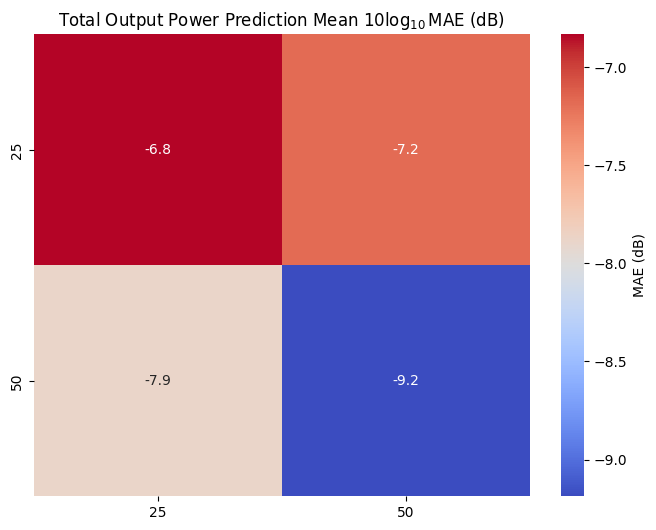

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_mae_to_db(model, testCSV):
    X_test, y_test = getCSVData(CVS_prepath + testCSV)
    print(X_test.shape)
    y_pred = model.predict(X_test).flatten()
    if y_test.ndim > 1:
        y_test = y_test.iloc[:, 0]
    mae = np.mean(np.abs(y_test - y_pred))
    mae_in_db = 10 * np.log10(mae)  # Convert MAE to dB
    return mae_in_db

# Create an empty DataFrame to store results
results_df = pd.DataFrame(index=["25", "50"], columns=["25", "50"])

# Apply evaluate_model_mae_to_db funtion to fill DataFrame
results_df.loc["25", "25"] = evaluate_model_mae_to_db(TL_model_25_random4_from_25_random_75_out, Test_25_4_random_out + '.csv')
results_df.loc["25", "50"] = evaluate_model_mae_to_db(TL_model_25_random4_from_50_random_75_out, Test_25_4_random_out + '.csv')
results_df.loc["50", "25"] = evaluate_model_mae_to_db(TL_model_50_random4_from_25_random_75_out, Test_50_4_random_out + '.csv')
results_df.loc["50", "50"] = evaluate_model_mae_to_db(TL_model_50_random4_from_50_random_75_out, Test_50_4_random_out + '.csv')

# Plot the results DataFrame in a heatmap form
plt.figure(figsize=(8, 6))
sns.heatmap(results_df.astype(float), annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'MAE (dB)'})
plt.title(r'Total Output Power Prediction Mean $10\log_{10}\mathrm{MAE}$ (dB)')
plt.show()

1/1 [==============================] - 0s 8ms/step


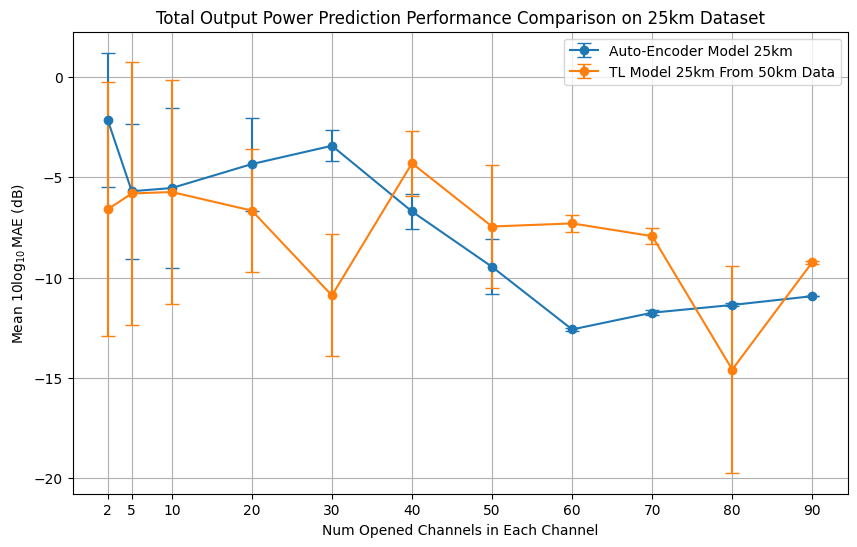

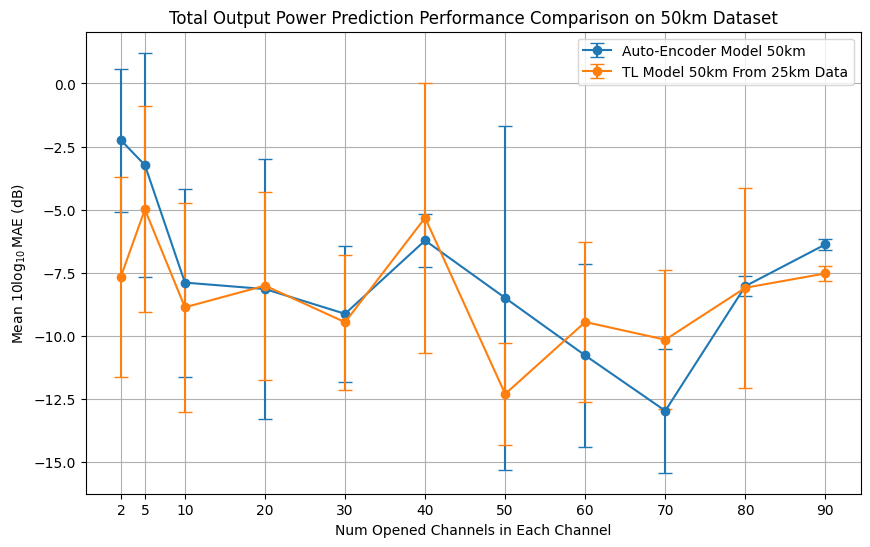

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def evaluate_model(model, test_data):
    testData = pd.read_csv(test_data,index_col=None)
    
    # Separate features and actual values
    X_test = testData.drop(columns=result_labels)
    y_test = testData[result_labels]

    # Record the performance of each group
    performances = []
    errors = []
    
    for num_channels in num_opened_channels_list:
        filtered_X_test = X_test[X_test['num_opened_channels'] == num_channels]
        filtered_y_test = y_test.loc[filtered_X_test.index]

        if not filtered_X_test.empty:
            y_pred = model.predict(filtered_X_test).flatten()
            mae = mean_absolute_error(filtered_y_test, y_pred)
            mae_db = 10 * np.log10(mae)
            
            errors_abs = np.abs(filtered_y_test.values.flatten() - y_pred)
            error_db = 10 * np.log10(errors_abs)
            std_error = np.std(error_db)
            
            performances.append(mae_db)
            errors.append(std_error)
        else:
            performances.append(np.nan)
            errors.append(np.nan)

    # print(len(performances))
    # print(len(errors))

    return performances, errors

# Function to plot performance evaluation results
def plot_performance(num_opened_channels, performances_1, errors_1, performances_2, errors_2, label_1, label_2, title):
    plt.figure(figsize=(10, 6))
    plt.errorbar(num_opened_channels, performances_1, yerr=errors_1, label=label_1, fmt='-o', capsize=5)
    plt.errorbar(num_opened_channels, performances_2, yerr=errors_2, label=label_2, fmt='-o', capsize=5)
    
    plt.title(title)
    plt.xlabel('Num Opened Channels in Each Channel')
    plt.ylabel(r'Mean $10\log_{10}\mathrm{MAE}$ (dB)')
    plt.xticks(num_opened_channels)
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate model performance
num_opened_channels_list = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
# Evaluate two models for the 25km dataset
performances_25_1, errors_25_1 = evaluate_model(base_model_25_random4_out, CVS_prepath + Test_25_4_random_out + ".csv")
performances_25_2, errors_25_2 = evaluate_model(TL_model_25_random4_from_50_random_75_out, CVS_prepath + Test_25_4_random_out + ".csv")


# Evaluate two models for the 50km dataset
performances_50_1, errors_50_1 = evaluate_model(base_model_50_random4_out, CVS_prepath + Test_50_4_random_out + ".csv")
performances_50_2, errors_50_2 = evaluate_model(TL_model_50_random4_from_25_random_75_out, CVS_prepath + Test_50_4_random_out + ".csv")

# Plot performance evaluation results
plot_performance(num_opened_channels_list, performances_25_1, errors_25_1, performances_25_2, errors_25_2, "Auto-Encoder Model 25km", "TL Model 25km From 50km Data", "Total Output Power Prediction Performance Comparison on 25km Dataset")
plot_performance(num_opened_channels_list, performances_50_1, errors_50_1, performances_50_2, errors_50_2, "Auto-Encoder Model 50km", "TL Model 50km From 25km Data", "Total Output Power Prediction Performance Comparison on 50km Dataset")

1/1 [==============================] - 0s 8ms/step


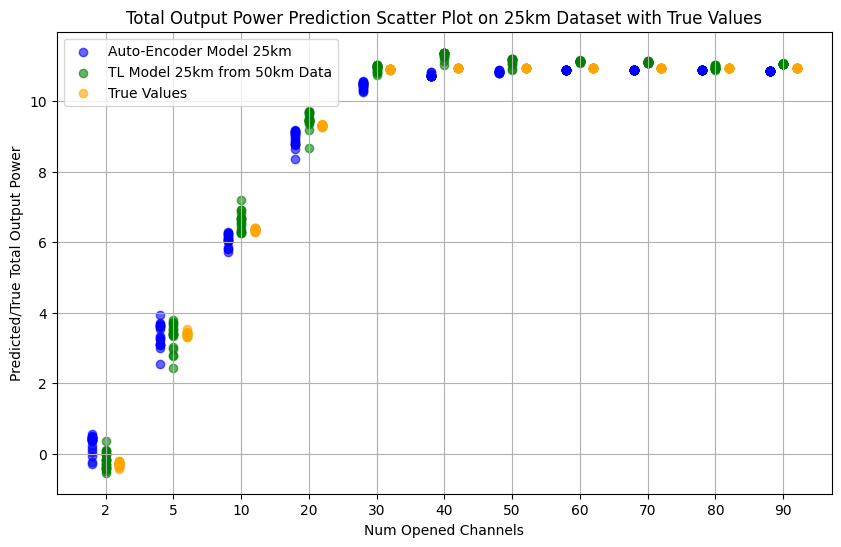

1/1 [==============================] - 0s 8ms/step


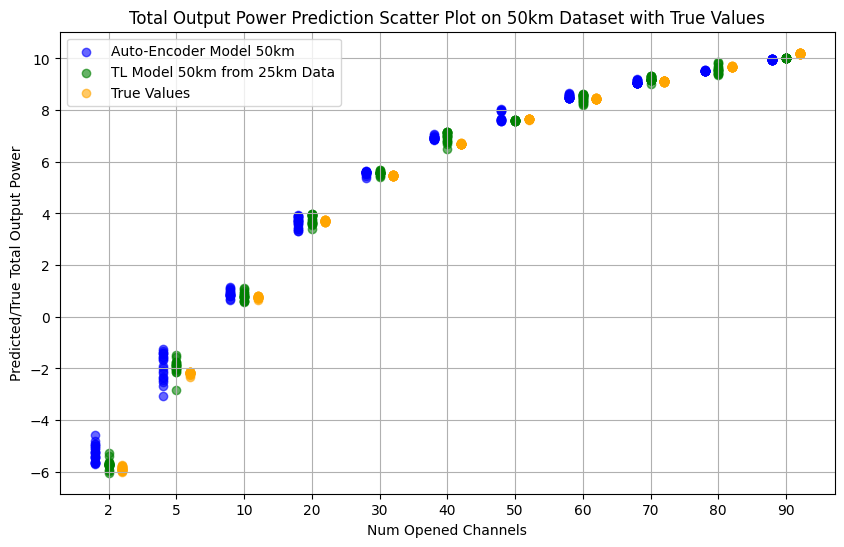

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def convert_to_dB(values):
    # Ensure all values are positive
    values = np.abs(values)
    # Avoid taking the logarithm of 0
    values[values == 0] = np.min(values[values > 0]) / 10
    return 10 * np.log10(values)

def extract_and_convert_true_values(test_data_path, num_opened_channels_list):
    testData = pd.read_csv(test_data_path, index_col=None)
    true_values_dB_list = []
    
    for num_channels in num_opened_channels_list:
        filtered_testData = testData[testData['num_opened_channels'] == num_channels]
        if not filtered_testData.empty:
            true_values = filtered_testData[result_labels].values.flatten()
            # true_values_dB = convert_to_dB(true_values)
            true_values_dB_list.append(true_values)
        else:
            true_values_dB_list.append([])

    return true_values_dB_list

def evaluate_model(model, test_data):
    testData = pd.read_csv(test_data,index_col=None)
    X_test = testData.drop(columns=result_labels)
    y_test = testData[result_labels]

    # Collect all predictions and errors under each num_opened_channels condition
    all_predictions = []
    all_errors = []
    
    for num_channels in num_opened_channels_list:
        filtered_X_test = X_test[X_test['num_opened_channels'] == num_channels]
        filtered_y_test = y_test.loc[filtered_X_test.index]

        if not filtered_X_test.empty:
            y_pred = model.predict(filtered_X_test).flatten()
            # y_pred_dB = convert_to_dB(y_pred) # Convert predictions to dB

            errors_abs = np.abs(filtered_y_test.values.flatten() - y_pred)
            
            all_predictions.append(y_pred)
            all_errors.append(errors_abs)
        else:
            all_predictions.append([])
            all_errors.append([])

    return all_predictions, all_errors

def plot_scatter(num_opened_channels_list, predictions_list, true_values_list, labels, title):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red', 'orange']  # Add colors to accommodate more groups of data
    offset = np.linspace(-0.2, 0.2, len(predictions_list) + 1)  # Generate offsets
    tolerance = 1e-5  # Set tolerance

    # Ensure each group of data is evenly distributed on the x-axis
    equidistant_x = np.arange(len(num_opened_channels_list))

    # Plot model prediction results
    for idx, predictions in enumerate(predictions_list):
        for i, x_pos in enumerate(equidistant_x):
            y_pred = predictions[i]
            # Filter out data points close to 0
            y_pred_filtered = y_pred[np.abs(y_pred) > tolerance]
            # y_pred_dB = convert_to_dB(y_pred_filtered) # Converting predicted value to dB
            x_values = np.full_like(y_pred_filtered, x_pos + offset[idx])
            plt.scatter(x_values, y_pred_filtered, color=colors[idx], alpha=0.6, label=labels[idx] if i == 0 else "")

    # Plot true value data points
    for i, x_pos in enumerate(equidistant_x):
        y_true = true_values_list[i]
        # Filtering data points close to 0
        y_true_filtered = y_true[np.abs(y_true) > tolerance]
        # y_true_dB = convert_to_dB(y_true_filtered) # Converting true value to dB
        x_values = np.full_like(y_true_filtered, x_pos + offset[-1])
        plt.scatter(x_values, y_true_filtered, color=colors[-1], alpha=0.6, label='True Values' if i == 0 else "")

    plt.title(title)
    plt.xlabel('Num Opened Channels')
    plt.ylabel(r'Predicted/True Total Output Power')
    # plt.ylim(-40,5)
    plt.xticks(equidistant_x, labels=num_opened_channels_list)
    plt.legend()
    plt.grid(True)
    plt.show()


# 模型性能评估
num_opened_channels_list = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]

true_values_25 = extract_and_convert_true_values(CVS_prepath + Test_25_4_random_out + '.csv', num_opened_channels_list)
true_values_50 = extract_and_convert_true_values(CVS_prepath + Test_50_4_random_out + '.csv', num_opened_channels_list)

# Evaluate models for the 25km dataset
all_predictions_25_1, all_errors_25_1 = evaluate_model(base_model_25_random4_out, CVS_prepath + Test_25_4_random_out + '.csv')
all_predictions_25_2, all_errors_25_2 = evaluate_model(TL_model_25_random4_from_50_random_75_out, CVS_prepath + Test_25_4_random_out + '.csv')

# Plot the scatter plot with error bars for the 25km dataset
# Evaluate models for the 25km dataset
plot_scatter(
plot_scatter(
    num_opened_channels_list, 
    [all_predictions_25_1, all_predictions_25_2], 
    true_values_25,
    ["Auto-Encoder Model 25km", "TL Model 25km from 50km Data"], 
    "Total Output Power Prediction Scatter Plot on 25km Dataset with True Values"
)

# Evaluate models for the 50km dataset
all_predictions_50_1, all_errors_50_1 = evaluate_model(base_model_50_random4_out, CVS_prepath + Test_50_4_random_out + '.csv')
all_predictions_50_2, all_errors_50_2 = evaluate_model(TL_model_50_random4_from_25_random_75_out, CVS_prepath + Test_50_4_random_out + '.csv')

# Plot the scatter plot with error bars for the 50km dataset
plot_scatter(
    num_opened_channels_list, 
    [all_predictions_50_1, all_predictions_50_2], 
    true_values_50,
    ["Auto-Encoder Model 50km", "TL Model 50km from 25km Data"], 
    "Total Output Power Prediction Scatter Plot on 50km Dataset with True Values"
)

7/7 [==============================] - 0s 781us/step


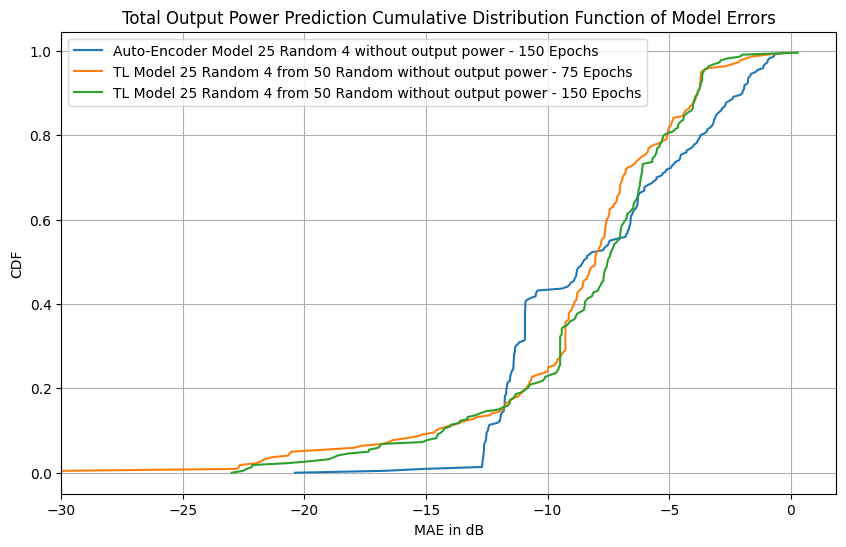

7/7 [==============================] - 0s 814us/step


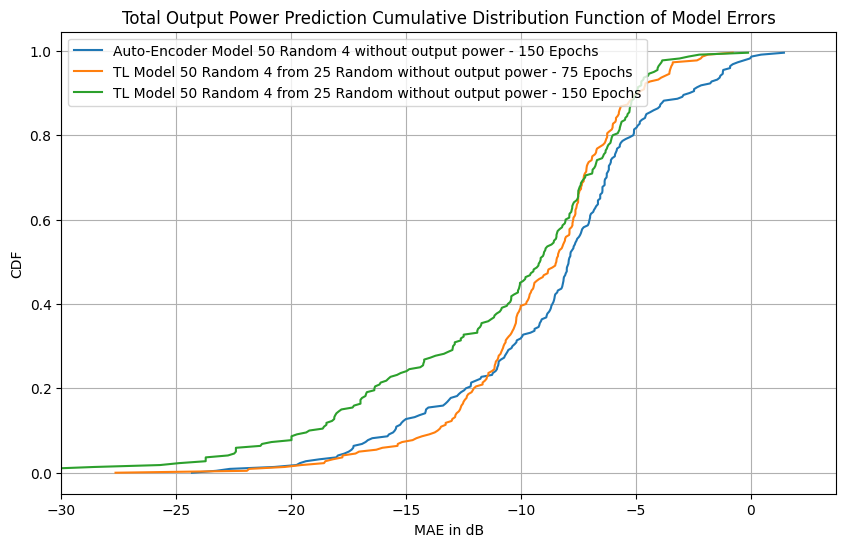

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_a_model(model, testCSV):
    X_test, y_test = getCSVData(CVS_prepath + testCSV)
    
    # Predictions
    y_pred = model.predict(X_test).flatten()

    # Ensure y_test is one-dimensional
    if y_test.ndim > 1:
        y_test = y_test.iloc[:, 0]  # Assuming y_test is a DataFrame and we're interested in the first column

    # Calculate errors
    errors = np.abs(y_test - y_pred)  # Using absolute error
    # Avoid division by zero and convert errors to dB
    errors_in_db = 10 * np.log10(errors)  # Adding a small value to avoid log(0)
    
    return errors_in_db
    # return errors

def plot_cdf(models, test_names, CVS_prepath, labels):
    plt.figure(figsize=(10, 6))
    for model, test_name, label in zip(models, test_names, labels):  # 添加label到循环中
        errors = evaluate_a_model(model, test_name)
        # 排序误差并计算CDF
        sorted_errors = np.sort(errors)
        yvals = np.arange(len(sorted_errors)) / float(len(sorted_errors))
        plt.plot(sorted_errors, yvals, label=label)  # 使用新标签

    # plt.xlabel('Absolute Error')
    plt.xlabel('MAE in dB')
    plt.ylabel('CDF')
    plt.title('Total Output Power Prediction Cumulative Distribution Function of Model Errors')
    plt.xlim(-30,)
    plt.legend()
    plt.grid(True)
    plt.show()

# Update the list of models to reflect the two models you want to verify
# For models predicting the 25km dataset
models_25 = [
    base_model_25_random4_out,
    TL_model_25_random4_from_50_random_75_out,
    TL_model_25_random4_from_50_random_150_out,
]
labels_25 = [
    "Auto-Encoder Model 25 Random 4 without output power - 150 Epochs",
    "TL Model 25 Random 4 from 50 Random without output power - 75 Epochs",
    "TL Model 25 Random 4 from 50 Random without output power - 150 Epochs",
]
test_names_25 = [
    Test_25_4_random_out + '.csv',
    Test_25_4_random_out + '.csv',
    Test_25_4_random_out + '.csv',
]

# For models predicting the 50km dataset
models_50 = [
    base_model_50_random4_out,
    TL_model_50_random4_from_25_random_75_out,
    TL_model_50_random4_from_25_random_150_out,
]
labels_50 = [
    "Auto-Encoder Model 50 Random 4 without output power - 150 Epochs",
    "TL Model 50 Random 4 from 25 Random without output power - 75 Epochs",
    "TL Model 50 Random 4 from 25 Random without output power - 150 Epochs",
]
test_names_50 = [
    Test_50_4_random_out + '.csv',
    Test_50_4_random_out + '.csv',
    Test_50_4_random_out + '.csv',
]

# Plot the CDF for models predicting the 25km dataset
plot_cdf(models_25, test_names_25, CVS_prepath, labels_25)

# Plot the CDF for models predicting the 50km dataset
plot_cdf(models_50, test_names_50, CVS_prepath, labels_50)

(880, 3) (880, 1)
Epoch 1/150
28/28 - 1s - loss: 92.6226 - mae: 9.1061 - val_loss: 185.1052 - val_mae: 12.8508 - 965ms/epoch - 34ms/step
Epoch 2/150
28/28 - 0s - loss: 87.7171 - mae: 9.0146 - val_loss: 112.3240 - val_mae: 9.9305 - 49ms/epoch - 2ms/step
Epoch 3/150
28/28 - 0s - loss: 85.4259 - mae: 8.9507 - val_loss: 93.1835 - val_mae: 9.0192 - 49ms/epoch - 2ms/step
Epoch 4/150
28/28 - 0s - loss: 82.9643 - mae: 8.9001 - val_loss: 81.3462 - val_mae: 8.4844 - 47ms/epoch - 2ms/step
Epoch 5/150
28/28 - 0s - loss: 81.3100 - mae: 8.8519 - val_loss: 73.8950 - val_mae: 8.1502 - 46ms/epoch - 2ms/step
Epoch 6/150
28/28 - 0s - loss: 79.7298 - mae: 8.7897 - val_loss: 68.7356 - val_mae: 7.9174 - 45ms/epoch - 2ms/step
Epoch 7/150
28/28 - 0s - loss: 77.8813 - mae: 8.7324 - val_loss: 65.6340 - val_mae: 7.8047 - 45ms/epoch - 2ms/step
Epoch 8/150
28/28 - 0s - loss: 77.1197 - mae: 8.6914 - val_loss: 63.5832 - val_mae: 7.7728 - 46ms/epoch - 2ms/step
Epoch 9/150
28/28 - 0s - loss: 76.1934 - mae: 8.6458 - va

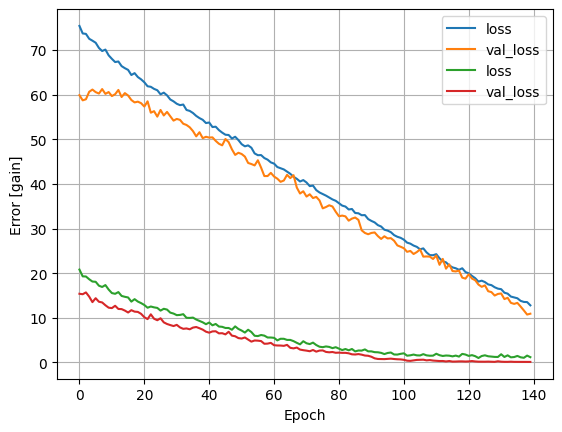

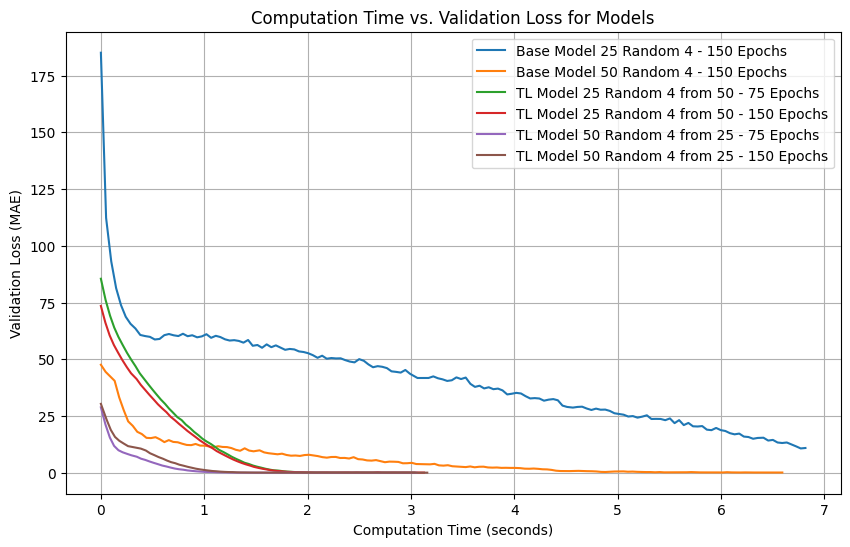

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import Callback, EarlyStopping
import time

class TimeAndLossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []  # Initialize a list for timing.
        self.val_losses = []  # Initialize a list for validation losses

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time())  # Record the current timestamp
        if logs:
            self.val_losses.append(logs.get('val_loss'))  # Record the validation loss

# model training and validation function
def integrate_and_validate_models():
    # Update the names list of training and testing sets to match six models
    train_test_pairs = [
        (Train_25_4_random_out, Test_25_4_random_out),
        (Train_50_4_random_out, Test_50_4_random_out),
        (Train_25_4_random_out, Test_25_4_random_out),
        (Train_25_4_random_out, Test_25_4_random_out),
        (Train_50_4_random_out, Test_50_4_random_out),
        (Train_50_4_random_out, Test_50_4_random_out)
    ]
    epochs_list = [150, 150, 150, 75, 150, 75, 150]
    base_models = [base_model_50_random4_out, base_model_25_random4_out]  # Base models for TL models

    time_loss_per_model = []

    for i, ((train_name, test_name), epochs) in enumerate(zip(train_test_pairs, epochs_list)):
        time_and_loss_history = TimeAndLossHistory()
        callbacks = [time_and_loss_history, EarlyStopping(monitor='val_loss', patience=20000)]
        
        if i < 2:  # For the first two base models
            model = train_base_model2(train_name, test_name, epochs, callbacks=callbacks)
        else:  # For transfer learning models
            base_model_index = (i - 2) % len(base_models)
            base_model = base_models[base_model_index]
            if base_model is None:
                print(f"Skipping TL model training because base model {base_model_index} is None.")
                continue  # Skip the current iteration
            model = train_tl_model(base_model, train_name, test_name, epochs = 75, callbacks=callbacks)
        
        time_loss_per_model.append((time_and_loss_history.times, time_and_loss_history.val_losses))
        
    # ploting
    plt.figure(figsize=(10, 6))
    labels = [
        "Base Model 25 Random 4 - 150 Epochs",
        "Base Model 50 Random 4 - 150 Epochs",
        "TL Model 25 Random 4 from 50 - 75 Epochs",
        "TL Model 25 Random 4 from 50 - 150 Epochs",
        "TL Model 50 Random 4 from 25 - 75 Epochs",
        "TL Model 50 Random 4 from 25 - 150 Epochs"
    ]

    # Plot the curve of computation time against validation loss for each model
    for i, (times, val_losses) in enumerate(time_loss_per_model):
        relative_times = [t - times[0] for t in times]  # Calculate relative time
        plt.plot(relative_times, val_losses, label=labels[i])

    plt.xlabel('Computation Time (seconds)')
    plt.ylabel('Validation Loss (MAE)')
    # plt.ylim(0, 0.2)
    plt.title('Computation Time vs. Validation Loss for Models')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to integrate models and perform validation
integrate_and_validate_models()
